In [1]:
# %load startup_config.ipy

# to hide warnings
import warnings
warnings.filterwarnings('ignore')

# to display graphics in svg format
%config InlineBackend.figure_format = 'svg'

# to make width of cells span whole width of screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# to view outputs of each line interactively
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# to display matplotlib outputs inline within the notebooks
%matplotlib inline

# for displaying tqdm progressbars
from tqdm import tqdm_notebook

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from io import StringIO
import pydotplus
from IPython.display import Image, display

In [3]:
df = pd.read_csv('../mlcourse.ai/data_files/telecom_churn.csv')

In [4]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [5]:
df.shape

(3333, 20)

### Convert International plan,  Voice mail plan and Churn features to 0 and 1 type

In [6]:
df['International plan'] = df['International plan'].map({'Yes': 1, 'No': 0})
df['Voice mail plan'] = df['Voice mail plan'].map({'Yes': 1, 'No': 0})

In [7]:
df['Churn'] = df['Churn'].astype('int')

In [8]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


### Save state feature as a Series and remove from dataframe

In [9]:
states = df.pop('State')

In [10]:
X, y = df.drop(['Churn'], axis = 1), df['Churn']

In [11]:
X.shape, y.shape

((3333, 18), (3333,))

### Split into training and holdout set

In [12]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size = 0.3, random_state = 17)

In [13]:
X_train.shape, X_holdout.shape, y_train.shape, y_holdout.shape

((2333, 18), (1000, 18), (2333,), (1000,))

### Build, train and evaluate the model

In [14]:
tree = DecisionTreeClassifier(random_state=17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [15]:
pred_holdout = tree.predict(X_holdout)

In [16]:
accuracy_score(y_holdout, pred_holdout)

0.921

### Perform hyperparameter tuning manually

In [17]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 17)

In [18]:
cv_accuracies_by_depth = []
holdout_accuracies_by_depth = []

max_depth_values = np.arange(2, 11)

for curr_max_depth in tqdm_notebook(max_depth_values):
    tree = DecisionTreeClassifier(max_depth = curr_max_depth, random_state = 17)
    
    # perform cross validation
    val_scores = cross_val_score(estimator = tree, X = X_train, y = y_train, cv = skf)
    cv_accuracies_by_depth.append(val_scores.mean())
    
    # assess model with holdout set
    tree.fit(X_train, y_train)
    curr_holdout_pred = tree.predict(X_holdout)
    holdout_accuracies_by_depth.append(accuracy_score(y_holdout, curr_holdout_pred))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

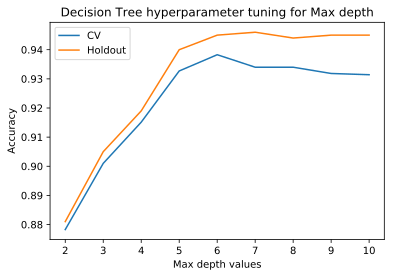

In [19]:
plt.plot(max_depth_values, cv_accuracies_by_depth, label = 'CV')
plt.plot(max_depth_values, holdout_accuracies_by_depth, label = 'Holdout')
plt.legend()
plt.xlabel('Max depth values')
plt.ylabel('Accuracy')
plt.title('Decision Tree hyperparameter tuning for Max depth');

### Perform hyperparameter tuning using GridSearchCV

In [20]:
params = { "max_depth": np.arange(2, 11), "min_samples_leaf": np.arange(2, 11) }

In [21]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 17)

In [22]:
best_tree = GridSearchCV(tree, params, cv = skf, n_jobs = -1, verbose = 1)

In [23]:
best_tree.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Done 398 out of 405 | elapsed:    3.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:    3.7s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]), 'min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [24]:
best_tree.best_params_

{'max_depth': 6, 'min_samples_leaf': 2}

In [25]:
best_tree.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [26]:
best_tree.best_score_

0.9417059579939991

In [27]:
pred_holdout_best = best_tree.predict(X_holdout)

In [28]:
accuracy_score(y_holdout, pred_holdout_best)

0.947

### Visualizing Decision Trees

<b>A complex tree with depth 6 can be difficult to visualize. Hence, let us create a new tree with depth 3 so that it can be visualized better.</b>

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

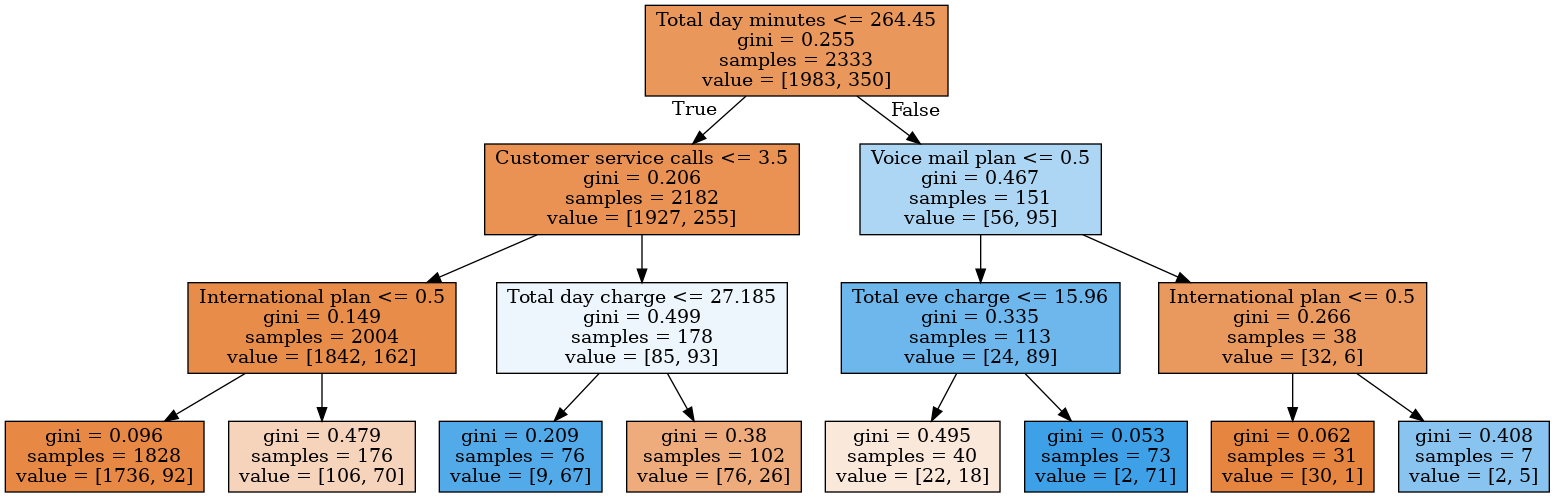

In [29]:
new_tree = DecisionTreeClassifier(random_state=17, max_depth=3)
new_tree.fit(X_train, y_train)

dot_data = StringIO()
export_graphviz(decision_tree = new_tree, 
                out_file = dot_data, 
                filled = True, feature_names = df.drop(['Churn'], axis = 1).columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
vis_tree = Image(graph.create_png())
display(vis_tree)